In [1]:
def read_list(path):
    l_s=[]
    l_n=[]
    with open(path,'r') as f:
        s=f.readline()
        l_s=s.split(',')
    l_s=l_s[0:-1]
    for item in l_s:
        l_n.append(float(item))
    return l_n

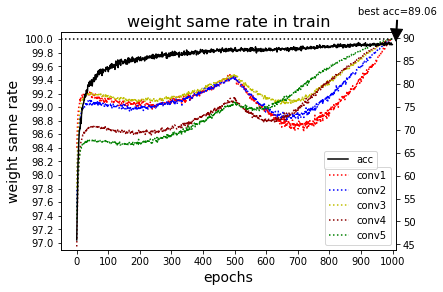

In [21]:
from pylab import *


acc_list=read_list('./same/acc.out')
conv1_list=read_list('./same/conv1.out')[1:]
conv2_list=read_list('./same/conv2.out')[1:]
conv3_list=read_list('./same/conv3.out')[1:]
conv4_list=read_list('./same/conv4.out')[1:]
conv5_list=read_list('./same/conv5.out')[1:]

plt.title('weight same rate in train',fontsize=16)
#设置图表标题和标题字号

plt.xlabel('epochs',fontsize=14)
#设置x轴标签及其字号
plt.ylabel('weight same rate',fontsize=14)
#设置y轴标签及其字号


#ax为两条坐标轴的实例
ax=plt.gca()

#把x轴的主刻度设置为1的倍数
ax.xaxis.set_major_locator(MultipleLocator(100))

#把y轴的主刻度设置为0.1的倍数
ax.yaxis.set_major_locator(MultipleLocator(0.2))


#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白
plt.xlim(-50,1010)

#把y轴的刻度范围设置为-5到110，同理，-5不会标出来，但是能看到一点空白
plt.ylim(96.9,100.1)


# plt.plot(range(len(conv1_list)),conv1_list,color='r',marker='*',linestyle='-',label="conv1")
# plt.plot(range(len(conv2_list)),conv2_list,color='b',marker='*',linestyle='-',label="conv2")
# plt.plot(range(len(conv3_list)),conv3_list,color='y',marker='*',linestyle='-',label="conv3")
# plt.plot(range(len(conv4_list)),conv4_list,color='darkred',marker='*',linestyle='-',label="conv4")
# plt.plot(range(len(conv5_list)),conv5_list,color='g',marker='*',linestyle='-',label="conv5")

ax.plot(range(len(conv1_list)),conv1_list,color='r',linestyle=':',label="conv1")
ax.plot(range(len(conv2_list)),conv2_list,color='b',linestyle=':',label="conv2")
ax.plot(range(len(conv3_list)),conv3_list,color='y',linestyle=':',label="conv3")
ax.plot(range(len(conv4_list)),conv4_list,color='darkred',linestyle=':',label="conv4")
ax.plot(range(len(conv5_list)),conv5_list,color='g',linestyle=':',label="conv5")

legend(loc='lower right')

#添加水平直线

plt.axhline(y=100,ls=":",c="black")

#添加垂直直线
#plt.axvline(x=4,ls="-",c="green")

ax1=ax.twinx()

#把x轴的主刻度设置为1的倍数
ax1.xaxis.set_major_locator(MultipleLocator(100))

#把y轴的主刻度设置为0.1的倍数
ax1.yaxis.set_major_locator(MultipleLocator(5))

ax1.plot(range(len(acc_list)),acc_list,color='black',linestyle='-',label="acc")


# 图例
legend(loc='lower right',bbox_to_anchor=(0.96, 0.35))


# 标记

plt.annotate('best acc=89.06', xy=(1010, 89.06), xytext=(890, 95),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.0))

# 文本

#plt.text(17, 85.3, 'acc=85.01')


plt.savefig('bi_weight_same_rate.png', dpi=800)

plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import math
from modules import ir_1w1a
from vgg import VGG_SMALL_1W1A

import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Calculate with ',device)

# Hyper parameters
batch_size = 256


# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
	transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])



transform_test = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# transform_train = transforms.Compose([
# 	transforms.RandomCrop(32, padding=4),
# 	transforms.RandomHorizontalFlip(),
# 	transforms.ToTensor(),
# ])



# transform_test = transforms.Compose([
# 	transforms.ToTensor(),
# ])

#Load data

trainset = torchvision.datasets.CIFAR10(root='../../../data', train=True, download=True,
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../../data', train=False, download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def update_lr(optimizer, lr):
	for param_group in optimizer.param_groups:
		param_group['lr'] = lr
        
def train(net,epoch=0):
	#criterion = nn.CrossEntropyLoss()
	#optimizer = torch.optim.Adam(net.parameters(), lr=lr)
	#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
	print('\nEpoch: %d' % (epoch+1))
	net.train()
	train_loss = 0
	correct = 0
	total = 0
	for batch_idx, (inputs, targets) in enumerate(trainloader):
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = net(inputs)
		loss = criterion(outputs, targets)
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
		_, predicted = outputs.max(1)
		total += targets.size(0)
		correct += predicted.eq(targets).sum().item()
		print('=',end='')
	print('\nLoss: {:.3f} | Acc: {:.3f}%% ({}/{})'.
                  format(train_loss, 100. * correct / total, correct, total))
	return 100. * correct / total
    
def test(net):
    global best_acc
    criterion = nn.CrossEntropyLoss()
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        print('Test: Loss: {:.3f} | Acc: {:.3f}%% ({}/{})'.
              format(test_loss, 100. * correct / total, correct, total))
    return 100. * correct / total

Calculate with  cuda:0
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [138]:
model = VGG_SMALL_1W1A().to(device)
T_min, T_max = 1e-1, 1e1
lr = 0.007
momentum = 0.9
weight_decay = 1e-4
best_acc=0
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=momentum, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, epochs, eta_min=0, last_epoch=-1)


def Log_UP(K_min, K_max, epoch):
    Kmin, Kmax = math.log(
        K_min) / math.log(10), math.log(K_max) / math.log(10)
    return torch.tensor([math.pow(10, Kmin + (Kmax - Kmin) / epochs * epoch)]).float().cuda()



bast_acc = 0

conv1_weight_now=0
conv1_same_list=[]
conv2_weight_now=0
conv2_same_list=[]
conv3_weight_now=0
conv3_same_list=[]
conv4_weight_now=0
conv4_same_list=[]
conv5_weight_now=0
conv5_same_list=[]
acc_list=[]
conv1_weight_product=0
conv2_weight_product=0
conv3_weight_product=0
conv4_weight_product=0
conv5_weight_product=0
conv1_weight_pre=0
conv1_weight_now=0
conv2_weight_pre=0
conv2_weight_now=0
conv3_weight_pre=0
conv3_weight_now=0
conv4_weight_pre=0
conv4_weight_now=0
conv5_weight_pre=0
conv5_weight_now=0

for i in range(epochs):
    print('*'*128)
    t = Log_UP(T_min, T_max, i)
    if (t < 1):
        k = 1 / t
    else:
        k = torch.tensor([1]).float().cuda()
    print('k=', k.item(), ', t=', t.item())

    model.conv1.k = k
    model.conv2.k = k
    model.conv3.k = k
    model.conv4.k = k
    model.conv5.k = k

    model.conv1.t = t
    model.conv2.t = t
    model.conv3.t = t
    model.conv4.t = t
    model.conv5.t = t
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    train(model, i)
    t = test(model)

    acc_list.append(t)

    if t > best_acc:
        best_acc = t
        torch.save(model.state_dict(), './model/delta_best.ckpt')
    print('best_acc=', best_acc)
    lr_scheduler.step()

    conv1_weight_pre=conv1_weight_now
    conv1_weight_now=model.conv1.bi_weight().cpu().detach().numpy().ravel()
    conv1_weight_product=conv1_weight_pre*conv1_weight_now
    conv1_same=0
    conv1_diff=0
    conv1_total=0
    for item in conv1_weight_product:
        if(item==1.0):
            conv1_same+=1
        else:
            conv1_diff+=1
        conv1_total+=1
    assert(conv1_same+conv1_diff==conv1_total)
    print('\n->conv1: total para={}, same={}%\n'.format(conv1_total,conv1_same/conv1_total*100))
    conv1_same_list.append(conv1_same/conv1_total*100)

    conv2_weight_pre=conv2_weight_now
    conv2_weight_now=model.conv2.bi_weight().cpu().detach().numpy().ravel()
    conv2_weight_product=conv2_weight_pre*conv2_weight_now
    conv2_same=0
    conv2_diff=0
    conv2_total=0
    for item in conv2_weight_product:
        if(item==1.0):
            conv2_same+=1
        else:
            conv2_diff+=1
        conv2_total+=1
    assert(conv2_same+conv2_diff==conv2_total)
    print('\n->conv2: total para={}, same={}%\n'.format(conv2_total,conv2_same/conv2_total*100))
    conv2_same_list.append(conv2_same/conv2_total*100)

    conv3_weight_pre=conv3_weight_now
    conv3_weight_now=model.conv3.bi_weight().cpu().detach().numpy().ravel()
    conv3_weight_product=conv3_weight_pre*conv3_weight_now
    conv3_same=0
    conv3_diff=0
    conv3_total=0
    for item in conv3_weight_product:
        if(item==1.0):
            conv3_same+=1
        else:
            conv3_diff+=1
        conv3_total+=1
    assert(conv3_same+conv3_diff==conv3_total)
    print('\n->conv3: total para={}, same={}%\n'.format(conv3_total,conv3_same/conv3_total*100))
    conv3_same_list.append(conv3_same/conv3_total*100)

    conv4_weight_pre=conv4_weight_now
    conv4_weight_now=model.conv4.bi_weight().cpu().detach().numpy().ravel()
    conv4_weight_product=conv4_weight_pre*conv4_weight_now
    conv4_same=0
    conv4_diff=0
    conv4_total=0
    for item in conv4_weight_product:
        if(item==1.0):
            conv4_same+=1
        else:
            conv4_diff+=1
        conv4_total+=1
    assert(conv4_same+conv4_diff==conv4_total)
    print('\n->conv4: total para={}, same={}%\n'.format(conv4_total,conv4_same/conv4_total*100))
    conv4_same_list.append(conv4_same/conv4_total*100)

    conv5_weight_pre=conv5_weight_now
    conv5_weight_now=model.conv5.bi_weight().cpu().detach().numpy().ravel()
    conv5_weight_product=conv5_weight_pre*conv5_weight_now
    conv5_same=0
    conv5_diff=0
    conv5_total=0
    for item in conv5_weight_product:
        if(item==1.0):
            conv5_same+=1
        else:
            conv5_diff+=1
        conv5_total+=1
    assert(conv5_same+conv5_diff==conv5_total)
    print('\n->conv5: total para={}, same={}%\n'.format(conv5_total,conv5_same/conv5_total*100))
    conv5_same_list.append(conv5_same/conv5_total*100)

********************************************************************************************************************************
k= 10.0 , t= 0.10000000149011612
current lr 7.00000e-03

Epoch: 1
Loss: 363.219 | Acc: 34.666%% (17333/50000)
Test: Loss: 65.657 | Acc: 42.370%% (4237/10000)
best_acc= 42.37

->conv1: total para=147456, same=0.0%


->conv2: total para=294912, same=0.0%


->conv3: total para=589824, same=0.0%


->conv4: total para=1179648, same=0.0%


->conv5: total para=2359296, same=0.0%

********************************************************************************************************************************
k= 6.309573650360107 , t= 0.15848931670188904
current lr 6.82870e-03

Epoch: 2
Loss: 312.771 | Acc: 44.378%% (22189/50000)
Test: Loss: 55.356 | Acc: 51.440%% (5144/10000)
best_acc= 51.44

->conv1: total para=147456, same=98.31949869791666%


->conv2: total para=294912, same=97.53214518229166%


->conv3: total para=589824, same=97.85512288411459%


->conv4: total p

In [139]:
l1_pre=conv1_weight_pre.tolist()
l2_pre=conv2_weight_pre.tolist()
l3_pre=conv3_weight_pre.tolist()
l4_pre=conv4_weight_pre.tolist()
l5_pre=conv5_weight_pre.tolist()
l_pre=l1_pre+l2_pre+l3_pre+l4_pre+l5_pre

l1_now=conv1_weight_now.tolist()
l2_now=conv2_weight_now.tolist()
l3_now=conv3_weight_now.tolist()
l4_now=conv4_weight_now.tolist()
l5_now=conv5_weight_now.tolist()
l_now=l1_now+l2_now+l3_now+l4_now+l5_now

In [142]:
l_write=bi_list_To_uint8_list(l_pre,1.0,-1.0)
for item in l_write:
    uint8_write('./same/1.out',item)

In [143]:
l_write=bi_list_To_uint8_list(l_now,1.0,-1.0)
for item in l_write:
    uint8_write('./same/2.out',item)

In [136]:
l1=conv1_weight_product.tolist()
l2=conv2_weight_product.tolist()
l3=conv3_weight_product.tolist()
l4=conv4_weight_product.tolist()
l5=conv5_weight_product.tolist()
l=l1+l2+l3+l4+l5
count_same=0
count_diff=0
count_total=0
for i in l:
    if(i==1.0):
        count_same+=1
    elif(i==-1.0):
        count_diff+=1
    count_total+=1
print(count_same)
print(count_diff)
print(count_total)
print(count_same/count_total*100)

4546629
24507
4571136
99.46387506300404


In [137]:
l_new=bi_list_To_uint8_list(l,1.0,-1.0)
len(l_new)

571392

In [134]:
for item in l_new:
    uint8_write('./same/diff.out',item)

In [62]:
def bi_list_To_uint8_list(bi_list,n_1=1.0,n_0=-1.0):
    lenth=len(bi_list)

    # 对齐到字节
    if lenth%8!=0:
        for i in range(8-(lenth%8)):
            bi_list.append(n_0)
        lenth=lenth+8-lenth%8

    uint8_list=[]

    for i in range(lenth):
        if bi_list[i]==n_1:
            bi_list[i]=1
        elif bi_list[i]==n_0:
            bi_list[i]=0
        else:
            print('error',bi_list[i])
            return

    for i in range(0,lenth,8):
        uint8_i=bi_list[i]*128+bi_list[i+1]*64+bi_list[i+2]*32+bi_list[i+3]*16+bi_list[i+4]*8+bi_list[i+5]*4+bi_list[i+6]*2+bi_list[i+7]
        uint8_i=int(uint8_i)
        uint8_list.append(uint8_i)
    return uint8_list

In [133]:
import struct
import os

def uint8_write(path,i):
    if(not(isinstance(i,int))):
        print(i,'is not a integer.')
        i=int(i)
    if(i<0 or i>255):
        print(i,'is not belong [0,255],uint8_write error.')
    else:
        bytes=struct.pack('B',i)
        with open(path,'ab') as binfile:
            binfile.write(bytes)